# Introduction and background

In this tutorial, we aim to learn unitary matrices using gradient descent. The tutorial reproduces [Lloyd et al.](https://arxiv.org/abs/1901.03431) and [Bobak et al.](https://arxiv.org/abs/2001.11897), and follows similar formalism as introduced in the two papers.

For a target unitary matrix, $U$, we intend to find optimal parameter vectors for the parameterized unitary $U(\vec{t}, \vec{\tau})$, such that $U(\vec{t}, \vec{\tau})$ approximates $U$ as closely as possible. Here, 

\begin{equation}\label{decomp}
    U(\vec{t}, \vec{\tau}) = e^{-iB\tau_{N}}e^{-iAt_{N}} ... e^{-iB\tau_{1}}e^{-iAt_{1}}
\end{equation}

where $\vec{t}$ and $\vec{\tau}$ are paramter vectors of size $N$.


In [17]:
import matplotlib.pyplot as plt 
import numpy as np
import tenpy 
from matplotlib import cm
from qutip import fidelity, Qobj, rand_ket
from scipy.stats import unitary_group
from scipy.linalg import expm

# Preparing the dataset

- We are going to be using random input kets as inputs, call them `ket_input` 
- Output kets are defined as `ket_output` = $U(\vec{t}, \vec{\tau})*|ket\_input>$

In [26]:
def make_dataset(m, d):
    r"""Prepares a dataset of input and output kets to be used for training.
    
    Args:
    ----
        m (int): Number of data points to be used for training
        d (int): Dimension of a (square) unitary matrix to be approximated
    
    Returns:
    --------
        data_points (tuple): tuple of lists containing (numpy arrays of) input and output kets respectively.
    """
    tar_unitr = unitary_group.rvs(d)  # Fixed random d-dimensional target unitary matrix that we want to learn
    ket_input = []
    ket_output = [] 
    for i in range(m):
        ket_input.append(rand_ket(d).full())
        ket_output.append(np.matmul(tar_unitr, ket_input[i]))  #Output data -- action of unitary on a ket states
    
    return (ket_input, ket_output)

m = 1000 # number of training data points
d = 2 #dimension of unitary 
N = 5 #size of parameter vectors tau and t
 
res = make_dataset(m, d)
ket_input, ket_output = res[0], res[1]

# Recipe for making $U(\vec{t}, \vec{\tau})$

We make $U(\vec{t}, \vec{\tau})$ by repeated application of $e^{-iB\tau_{k}}e^{-iAt_{k}}$ at k-th step. We multiply $e^{-iB\tau_{k}}e^{-iAt_{k}}$ in a [QAOA](https://arxiv.org/abs/1411.4028) like fashion $N$ times, where N is the dimension of $\vec{t}$ and $\vec{\tau}$. Higher N $\rightarrow$ better approximation.

In [Lloyd et al.](https://arxiv.org/abs/1901.03431) and [Bobak et al.](https://arxiv.org/abs/2001.11897), matrices $A$ and $B$ are chosen from a Gaussian Unitary Ensemble (GUE). We use `tenpy` to sample $A$ and $B$ from GUE.

In [27]:
A = tenpy.linalg.random_matrix.GUE((d,d)) # tenpy for sampling A and B from GUE
B = tenpy.linalg.random_matrix.GUE((d,d)) 

def make_unitary(N, params):
    r"""Retruns a paramterized unitary matrix.
    
    : math:: \begin{equation}\label{decomp}
                U(\vec{t}, \vec{\tau}) = e^{-iB\tau_{N}}e^{-iAt_{N}} ... e^{-iB\tau_{1}}e^{-iAt_{1}}
             \end{equation}
             
    Args:
    ----
        N (int): Size of the parameter vectors, :math:`\tau` and :math:`\t`
        params (:obj:`np.ndarray`): parameter vector of size :math:`2 * N` where the first half parameters are  
                                   :math:`\vec{t}` params and the second half encodes \vec{\tau}) parameters.
                                   
    Returns:
        unitary (:obj:`np.ndarray`): numpy array representation of paramterized unitary matrix 
    """
    unitary = np.eye(d)
    for i in range (N): 
        unitary = np.matmul(np.matmul(expm(-1j*B*params[i+N][0]),expm(-1j*A*params[i][0])), unitary)
    
    return unitary 

# Criteria for learnability -- the cost function
The cost function formulation of gradient descent learning is defined by the authors is as follows:

$\begin{equation} \label{err_ps}
        E = 1 - (\frac{1}{M})\sum_{l} \langle \psi_{l}|U^{\dagger} U(\vec{t},\vec{\tau})|\psi_{l}\rangle
\end{equation}$, 

where $ |\psi_{l}>$ is the training (or testing) data points -- in this case, kets. We implement the same formulation below.

In [28]:
def cost(params, inputs, outputs):
    r"""Calculates the cost/error on the whole training datat set.
    
    Args:
    ----
        params: parameters :math:`\t` and :math:`\tau` in :math:`U^{\dagger} U(\vec{t},\vec{\tau})`
        inputs: input kets :math:`|\psi_{l}>` in the dataset 
        outputs: output kets :math:`U(\vec{t}, \vec{\tau})*|ket\_input>` in the dataset
    
    Returns:
    -------
        cost (float): cost (evaluated on the enitre dataset) of parametrizing 
                     :math:`\tau` in :math:`U^{\dagger} U(\vec{t},\vec{\tau})` with `params`                  
    """
    loss = 0.0
    for k in range(m): 
        pred = np.matmul(make_unitary(N, params), inputs[k]) #prediction wth parametrized unitary
        loss += np.absolute(np.real(np.matmul(outputs[k].conjugate().T, pred)))
        # TODO check real and abs in loss above since   
        # it's not in the original paper
    return 1 - (1 / m) * loss 

# Differentation of the cost function

Gradient descent is a first order method, so one definitely needs to take the derivative of the cost function. Analytically, the gradient of above error term, or the cost function, is 

$ 
\begin{equation}
    \frac{\partial}{\partial \tau_{k}}E(\vec{t},\vec{\tau}) = -\frac{1}{M}\sum_{l} \langle \psi_{l}|U^{\dagger}[e^{-iAt_{N}}e^{-iB\tau_{N}} ... (-iB)e^{-iB\tau_{k}}e^{-iAt_{k}} ... e^{-iB\tau_{1}}e^{-iAt_{1}}]|\psi_{l}\rangle
\end{equation}
$

# **TODO Shahnawaz to recheck the eq** above

In [29]:
#TODO this function can be made elegant
#TODO test the derivative func
def der_cost(params, inputs, outputs):
    r"""Returns the derivative of the cost function.
    
    Args:
    ----
        params: parameters :math:`\t` and :math:`\tau` in :math:`U^{\dagger} U(\vec{t},\vec{\tau})`
        inputs: input kets :math:`|\psi_{l}>` in the dataset 
        outputs: output kets :math:`U(\vec{t}, \vec{\tau})*|ket\_input>` in the dataset
        
    Returns:
    -------
        der (obj:`np.array`): Cost function value w.r.t each of the 2 * N parameters    
    """
    der_params = []
    for i in range(2 * N):
            dU = np.eye(d)
            if i < N:
                for k in range(N):
                    if k == i:
                        term_t = np.matmul(expm(-1j * B * params[k + N][0]), 
                                           np.matmul(-1j * A, expm(-1j * A * params[k][0])))
                        dU = np.matmul(term_t, dU)
                    elif k != i :
                        dU = np.matmul(np.matmul(expm(-1j * B * params[k + N][0]), 
                                                 expm(-1j * A * params[k][0])), dU)

                
                sum_t = 0
                for j in range(m):
                    pred_t = np.matmul(dU, inputs[j])
                    sum_t += np.real(np.matmul(outputs[j].conjugate().T,pred_t))
                
                der_params.append((-1/m) * sum_t)
           
            elif i >= N: 
                for j, k in enumerate(range(N, 2 * N)):
                    if k == i:
                        term_tau = np.matmul(np.matmul(-1j * B, expm(-1j * B * params[j + N][0])), 
                                                       expm(-1j * A * params[j][0]))
                        dU = np.matmul(term_t, dU)
                    elif k != i:
                        dU = np.matmul(np.matmul(expm(-1j * B * params[j + N][0]),
                                                 expm(-1j * A * params[j][0])), dU)

                sum_tau = 0
                for j in range(m):
                    pred_tau = np.matmul(dU, inputs[j])
                    sum_tau += np.real(np.matmul(outputs[j].conjugate().T, pred_tau))
                
                der_params.append((-1/m) * sum_tau)
                
                        
    der_params = np.asarray(der_params).reshape(2 * N, 1)
    return der_params

# Performance Metric -- fidelity

While cost is a valid metric to judge the learnability. We introduce another (commonly used) metric, fidelty between the predicted and the output (label) states as a sanity check. 

In [30]:
def test_score(params, x, y):
    """Calculates the avergage fidelity between the predicted and output kets for a given 
       on the whole dataset.
       
       Args:
       ----
           params: parameters :math:`\t` and :math:`\tau` in :math:`U^{\dagger} U(\vec{t},\vec{\tau})`
           x: input kets :math:`|\psi_{l}>` in the dataset 
           y: output kets :math:`U(\vec{t}, \vec{\tau})*|ket\_input>` in the dataset
           
       Returns:
       -------
           fidel (float): fidelity between :math:`U(\vec{t}, \vec{\tau})*|ket\_input>` and
                          the output (label) kets for parameters :math:`\vec{t}, \vec{\tau}`
                          averaged over the entire training set.
       """
    fidel = 0
    for i in range(m):
        pred = np.matmul(make_unitary(N, params), x[i])
        step_fidel = fidelity(Qobj(pred), Qobj(y[i]))
        fidel += step_fidel
        
        
    return fidel/m

# Gradient Descent Implementation

We implement gradient descent based on 

$\begin{equation} \label{gd}
    t_{k} = t_{k} - \alpha \frac{\partial}{\partial t_{k}}E(\vec{t},\vec{\tau})
\end{equation}$

for a single parameter $t_{k}$, where $\alpha$ is the learning rate. 

In [51]:
epochs = 10
alpha = 0.2
tol = 1e-7
diff = 1
max_iters = 30
iters = 0
loss_hist = []
fidel_hist = []
params_hist = []
weights = np.random.rand(2 * N, 1)

for epoch in range(epochs):
    iters = 0
    tol = 1e-7
    diff = 1
    while np.all(diff > tol) and iters < max_iters:
        prev_weights = weights
        weights = weights - alpha * (der_cost(prev_weights, ket_input, ket_output))
        iters += 1
        diff = np.absolute(weights - prev_weights)
    loss = cost(weights, ket_input, ket_output).item() # convert numpy (1,1) array to native python float
    avg_fidel = test_score(weights, ket_input, ket_output)
    progress = [epoch+1, loss, avg_fidel]
    loss_hist.append(loss)
    fidel_hist.append(avg_fidel)
    params_hist.append(weights)
    #if ((epoch) % 10 == 1):
    print("Epoch: {:2f} | Loss: {:3f} | Fidelity: {:3f}".format(*np.asarray(progress)))
    
opt_params = weights

Epoch: 1.000000 | Loss: 0.494980 | Fidelity: 0.516216
Epoch: 2.000000 | Loss: 0.528217 | Fidelity: 0.559366
Epoch: 3.000000 | Loss: 0.539450 | Fidelity: 0.577406
Epoch: 4.000000 | Loss: 0.566175 | Fidelity: 0.618329
Epoch: 5.000000 | Loss: 0.583128 | Fidelity: 0.652748
Epoch: 6.000000 | Loss: 0.289333 | Fidelity: 0.862463
Epoch: 7.000000 | Loss: 0.255595 | Fidelity: 0.904895
Epoch: 8.000000 | Loss: 0.484965 | Fidelity: 0.764734
Epoch: 9.000000 | Loss: 0.508952 | Fidelity: 0.807493
Epoch: 10.000000 | Loss: 0.103959 | Fidelity: 0.971381


# Efficient reconstruction of the target unitary
The papers claim that if the dimension, N, of the parameters is of order $O(d^{2})$, where $d$ is the dimension of the unitary, then $U(\vec{t},\vec{\tau})$ is constructed _efficiently_. We verify this claim with $d = 2$ and $N = 5$. Fidelity can be further improved, and loss reduced, if training is carried on for a greater number of epochs and the learning rate $\alpha$ is tuned further.

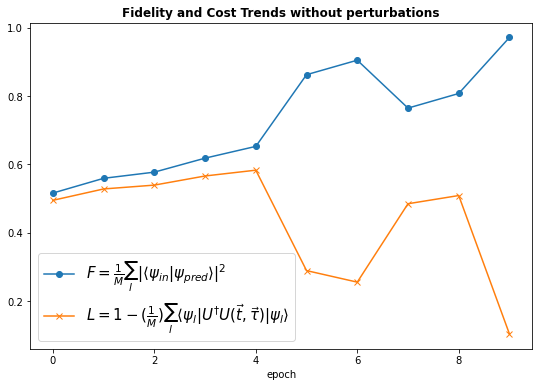

In [53]:
plt.figure(figsize=(9, 6))
plt.plot(range(epochs), np.asarray(fidel_hist).ravel(), marker='o', 
         label=r"$F = \frac{1}{M}\sum_{l}| \langle \psi_{in} | \psi_{pred} \rangle |^2$")
plt.plot( range(epochs), np.asarray(loss_hist).ravel(), marker='x',
        label=r"$L = 1 - (\frac{1}{M})\sum_{l}\langle \psi_{l} | U ^{\dagger} U(\vec{t},\vec{\tau}) | \psi_{l} \rangle$")
plt.title("Fidelity and Cost Trends", fontweight="bold")
plt.legend(["Fidelity","Loss"])
plt.xlabel("epoch")
plt.legend(loc=0, prop={'size': 15})

We would expect the average fidelity, $F$, to increase since we defined fidelity to be between $U(\vec{t}, \vec{\tau})*|ket\_input>$ and the output (label) kets for parameters $\vec{t}, \vec{\tau}$ averaged over the entire training set. The expected pattern is reflected in the training graph above with the loss, $L$, is the cost that we aim to minimize decreasing progressively. The dips in the graph are due to highly non-convex landscape of the cost function as authors report in the paper.